### Imports

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

### Plotting Functions

In [ ]:
def plot_combined_sirv_dynamics(excel_path, output_folder, vax):
    county_order = [
        "Alachua", "Baker", "Bay", "Bradford", "Brevard", "Broward", "Calhoun", "Charlotte", "Citrus", "Clay",
        "Collier", "Columbia", "DeSoto", "Dixie", "Duval", "Escambia", "Flagler", "Franklin", "Gadsden", "Gilchrist",
        "Glades", "Gulf", "Hamilton", "Hardee", "Hendry", "Hernando", "Highlands", "Hillsborough", "Holmes", 
        "Indian River", "Jackson", "Jefferson", "Lafayette", "Lake", "Lee", "Leon", "Levy", "Liberty", "Madison", 
        "Manatee", "Marion", "Martin", "Miami-Dade", "Monroe", "Nassau", "Okaloosa", "Okeechobee", "Orange", 
        "Osceola", "Palm Beach", "Pasco", "Pinellas", "Polk", "Putnam", "Santa Rosa", "Sarasota", "Seminole", 
        "St. Johns", "St. Lucie", "Sumter", "Suwannee", "Taylor", "Union", "Volusia", "Wakulla", "Walton", "Washington"
    ]
    # Load necessary sheets from the Excel file
    required_sheets = ['sus', 'infe', 'rec']
    available_sheets = pd.ExcelFile(excel_path).sheet_names
    
    # Check if vaccination data exists
    has_vax_data = 'vac' in available_sheets
    if has_vax_data:
        required_sheets.append('vac')
    
    # Read data only for available sheets
    sirv_data = {sheet: pd.read_excel(excel_path, sheet_name=sheet) for sheet in required_sheets}

    sirv_proportions = []
    regions = sirv_data['sus']['Unnamed: 0'].values  # Region identifiers
    time_periods = range(1, sirv_data['sus'].shape[1])  # Exclude first column

    # Calculate SIRV proportions
    for idx, region in enumerate(regions):
        sus_row = sirv_data['sus'].iloc[idx, 1:].values
        infe_row = sirv_data['infe'].iloc[idx, 1:].values
        rec_row = sirv_data['rec'].iloc[idx, 1:].values
        
        if has_vax_data and vax:
            vac_row = sirv_data['vac'].iloc[idx, 1:].values
            for t, (s, i, r, v) in enumerate(zip(sus_row, infe_row, rec_row, vac_row)):
                total_population = s + i + r + v
                if total_population > 0:
                    sirv_proportions.append([region, t + 1, s / total_population, i / total_population, r / total_population, v / total_population])
        else:
            for t, (s, i, r) in enumerate(zip(sus_row, infe_row, rec_row)):
                total_population = s + i + r
                if total_population > 0:
                    sirv_proportions.append([region, t + 1, s / total_population, i / total_population, r / total_population])

    # Define column names dynamically
    columns = ["Region", "TimePeriod", "S_Proportion", "I_Proportion", "R_Proportion"]
    if has_vax_data and vax:
        columns.append("V_Proportion")

    sirv_df = pd.DataFrame(sirv_proportions, columns=columns)

    # Create a 23x3 grid plot
    fig, axes = plt.subplots(23, 3, figsize=(15, 60), sharex=True, sharey=True)
    title_suffix = "(Vaccinated)" if has_vax_data and vax else "(Unvaccinated)"
    fig.suptitle(f"SIRV Dynamics Across All Regions {title_suffix}", fontsize=16, y=0.92)

    for idx, region in enumerate(sirv_df["Region"].unique()):
        row, col = divmod(idx, 3)
        region_data = sirv_df[sirv_df["Region"] == region]
        ax = axes[row, col]
        
        ax.plot(region_data["TimePeriod"], region_data["S_Proportion"], label="S", color="blue")
        ax.plot(region_data["TimePeriod"], region_data["I_Proportion"], label="I", color="red")
        ax.plot(region_data["TimePeriod"], region_data["R_Proportion"], label="R", color="green")
        
        if has_vax_data and vax:
            ax.plot(region_data["TimePeriod"], region_data["V_Proportion"], label="V", color="orange")

        ax.set_title(f"{county_order[idx]} County", fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(False)

    # Adjust layout and save
    fig.tight_layout(rect=[0, 0.03, 1, 0.9])
    combined_plot_path = os.path.join(output_folder, "combined_sirv_dynamics.png")
    plt.savefig(combined_plot_path, bbox_inches="tight")
    print(f"Combined SIRV dynamics plot saved to '{combined_plot_path}'")
    plt.show()


def plot_total_unmet_demand(excel_path, output_folder, vax):
    # Load the 'u' sheet from the Excel file
    u_data = pd.read_excel(excel_path, sheet_name='u')

    # Sum unmet demand across all regions for each time period
    time_periods = u_data.columns[1:]  # Exclude the first column (region identifier)
    total_unmet_demand = u_data.iloc[:, 1:].sum(axis=0)  # Sum over all regions for each time period

    # Plot total unmet demand over time
    plt.figure(figsize=(12, 6))
    plt.plot(time_periods, total_unmet_demand, marker='o', linestyle='-', color='cornflowerblue')
    if vax:  
        plt.title("Total Unmet Hospital Demand Over Time (Vaccinated)", fontsize=24)
    else:
        plt.title("Total Unmet Hospital Demand Over Time (Unvaccinated)", fontsize=24)
    plt.xlabel("Decision Period", fontsize = 16)
    plt.ylabel("Total Unmet Hospital Demand", fontsize = 16)
    #plt.grid(True)

    # Save plot
    plot_path = os.path.join(output_folder, "total_unmet_demand.png")
    plt.savefig(plot_path)
    print(f"Total unmet demand plot saved to '{plot_path}'")
    plt.show()
    

def plot_total_infections_comparison(vaxPath, noVaxPath, output_folder):
    # Load the 'infe' sheet from both Excel files
    vax_data = pd.read_excel(vaxPath, sheet_name='infe')
    no_vax_data = pd.read_excel(noVaxPath, sheet_name='infe')

    # Extract time periods (assume the same columns for both datasets)
    time_periods = vax_data.columns[1:]  # Exclude the first column (region identifier)

    # Sum infections across all regions for each time period
    total_infections_vax = vax_data.iloc[:, 1:].sum(axis=0)  # Vaccinated
    total_infections_no_vax = no_vax_data.iloc[:, 1:].sum(axis=0)  # Unvaccinated

    # Plot total infections over time for both cases
    plt.figure(figsize=(12, 6))
    plt.plot(time_periods, total_infections_vax, marker='o', linestyle='-', markersize=4, color='cornflowerblue', label="Vaccinated")
    plt.plot(time_periods, total_infections_no_vax, marker='s', linestyle='-', markersize=4, color='tomato', label="Unvaccinated")
    
    #plt.title("Total Infections Over Time", fontsize=24)
    plt.xlabel("Decision Period", fontsize=12)
    plt.ylabel("Total Infections", fontsize=12)
    plt.yscale('log')
    plt.legend(fontsize=14)
    plt.grid(True)
    
    # Set X-axis tick marks to show every ten days
    plt.xticks(ticks=(np.arange(0, 160, 10)))

    # Save plot
    plot_path = os.path.join(output_folder, "totalInfectionComparison.png")
    plt.savefig(plot_path)
    plt.show()
    print(f"Total infections comparison plot saved to {plot_path}")

def plot_total_unmet_demand_comparison(vaxPath, noVaxPath, output_folder):
    # Load the 'u' sheet from both Excel files
    vax_data = pd.read_excel(vaxPath, sheet_name='u')
    no_vax_data = pd.read_excel(noVaxPath, sheet_name='u')

    # Extract time periods (assuming the first column is a region identifier)
    time_periods = pd.to_numeric(vax_data.columns[1:], errors='coerce')

    # Sum unmet demand across all regions for each time period
    total_unmet_demand_vax = vax_data.iloc[:, 1:].sum(axis=0)
    total_unmet_demand_no_vax = no_vax_data.iloc[:, 1:].sum(axis=0)

    # Create the comparison plot
    plt.figure(figsize=(12, 6))
    plt.plot(time_periods, total_unmet_demand_vax, marker='o', linestyle='-', markersize=4, color='cornflowerblue', label="Vaccinated")
    plt.plot(time_periods, total_unmet_demand_no_vax, marker='s', linestyle='-', markersize=4, color='tomato', label="Unvaccinated")

    #plt.title("Total Unmet Hospital Demand Over Time", fontsize=20)
    plt.xlabel("Decision Period", fontsize=12)
    plt.ylabel("Total Unmet Hospital Demand", fontsize=12)
    # If a logarithmic scale is desired, uncomment the next line:
    # plt.yscale('log')
    plt.legend(fontsize=14)
    plt.grid(True)

    # Set X-axis tick marks to show every ten days
    tick_positions = np.arange(0, len(time_periods), 10)
    plt.xticks(ticks=(np.arange(0, 160, 10)))

    # Save and display the plot
    plot_path = os.path.join(output_folder, "totalUnmetDemandComparison.png")
    plt.savefig(plot_path, bbox_inches="tight")
    plt.show()
    print(f"Total unmet demand comparison plot saved to {plot_path}")




### Visualization Calls

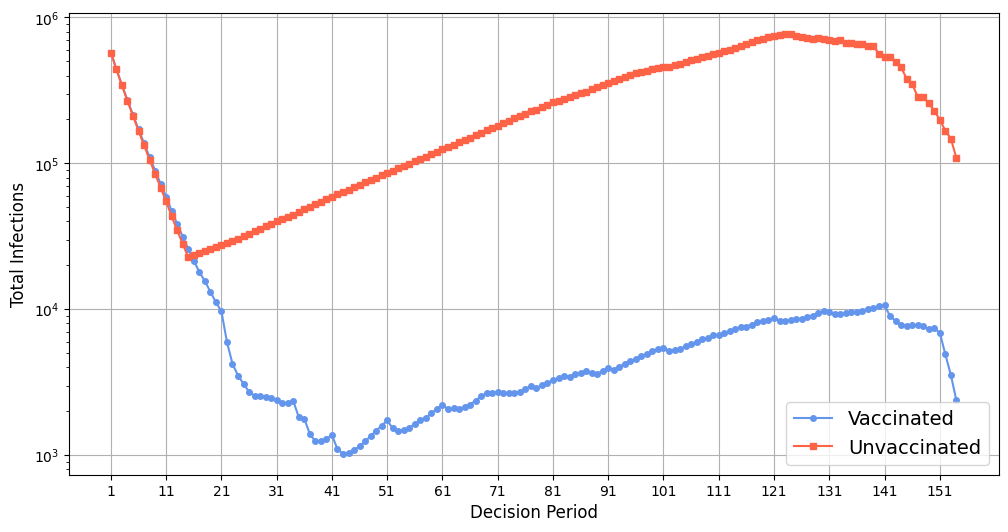

Total infections comparison plot saved to diseaseDynamics\totalInfectionComparison.png


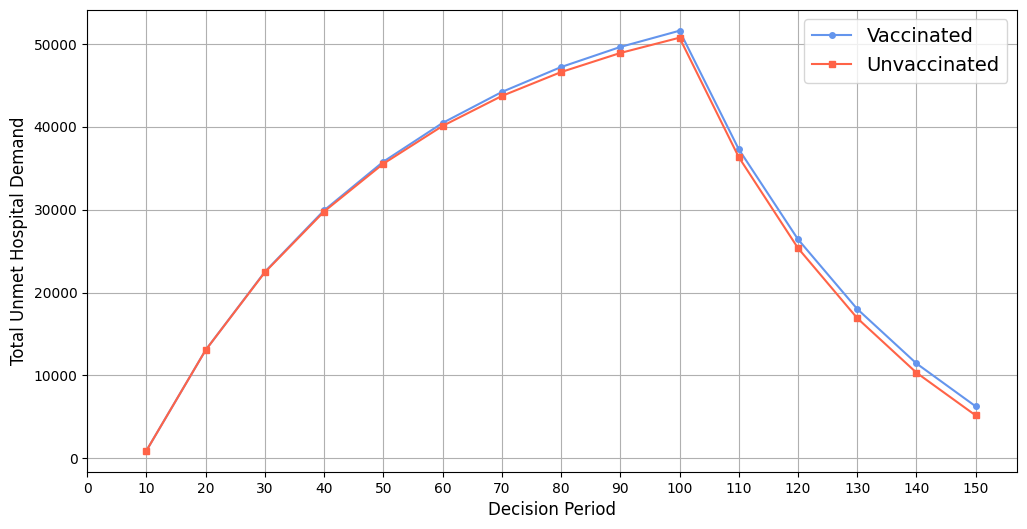

Total unmet demand comparison plot saved to diseaseDynamics\totalUnmetDemandComparison.png


In [27]:
# File path to the Excel sheet
vaxPath = r"outputData\results_ten_0.1.xlsx"
noVaxPath = r"outputData\results_ten_novac.xlsx"
output_folder = r"diseaseDynamics"
os.makedirs(output_folder, exist_ok=True)

vax = True

#plot_combined_sirv_dynamics(excel_file, output_folder, vax)
#plot_total_unmet_demand(excel_file, output_folder, vax)
plot_total_infections_comparison(vaxPath, noVaxPath, output_folder)
plot_total_unmet_demand_comparison(vaxPath, noVaxPath, output_folder)
